In [15]:
# matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
base = automap_base()
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
conn = engine.connect()

In [19]:
data_m = pd.read_sql("SELECT * FROM measurement", conn)
data_m.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [20]:
data_s = pd.read_sql("SELECT * FROM station", conn)
data_s.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [21]:
# reflect an existing database into a new model

# reflect the tables
base.prepare(autoload_with=engine)

In [22]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
from sqlalchemy import desc
most_recent_date = session.query(measurement).order_by(desc('date')).first()
date = most_recent_date.date
print(date)

2017-08-23


<AxesSubplot:xlabel='date', ylabel='precipation'>

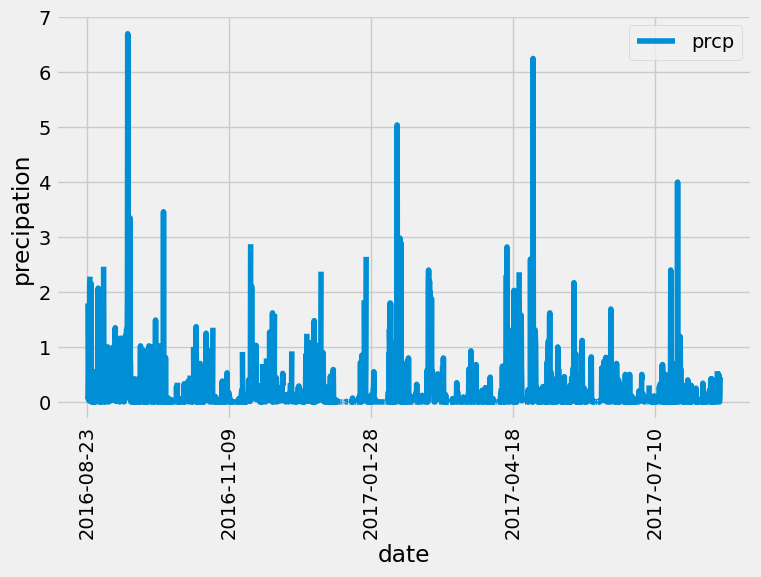

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
recent_12_data = session.query(measurement).filter(measurement.date >= '2016-08-23')


# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.read_sql(recent_12_data.statement, recent_12_data.session.bind)
date_prcp_df = date_prcp_df.drop(columns=['id','station','tobs'])
date_prcp_df = date_prcp_df.set_index('date')

# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values(by = 'date')


# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot(ylabel = 'precipation', use_index = True, figsize=(8, 5),rot=90)



In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurement).group_by(measurement.station).count()
station_count


9

In [30]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
group = session.query(measurement).group_by(measurement.station)
count = []
for c in group:
    count.append(session.query(measurement).filter(measurement.station == c.station).count())
    print(c.station, session.query(measurement).filter(measurement.station == c.station).count())
    max_count = max(count)
    if session.query(measurement).filter(measurement.station == c.station).count() == max_count:
        most_active_station = c.station

print(most_active_station)


USC00511918 1979
USC00513117 2709
USC00514830 2202
USC00516128 2612
USC00517948 1372
USC00518838 511
USC00519281 2772
USC00519397 2724
USC00519523 2669
USC00519281


In [31]:
# descending order
session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs = session.query(measurement).filter(measurement.station == most_active_station)
tobs_of_most_active_station = []
for t in tobs:
    tobs_of_most_active_station.append(t.tobs)

lowest_temp = min(tobs_of_most_active_station)
highest_temp = max(tobs_of_most_active_station)
from statistics import mean
average_temp = mean(tobs_of_most_active_station)
print( f"In the most active station ({most_active_station}), the lowest temperature is {lowest_temp},\
       highest temperature is {highest_temp}, and the average temperature is {average_temp}.")

In the most active station (USC00519281), the lowest temperature is 54.0,       highest temperature is 85.0, and the average temperature is 71.66378066378067.


In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months_temp = session.query(measurement).filter(measurement.station == most_active_station).filter(measurement.date >= '2016-08-23')
last_12_months_temp_df = pd.read_sql(last_12_months_temp.statement, last_12_months_temp.session.bind)
last_12_months_temp_df = last_12_months_temp_df.drop(columns=['id','station','prcp'])
last_12_months_temp_df


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


Text(0.5, 0, 'temperature')

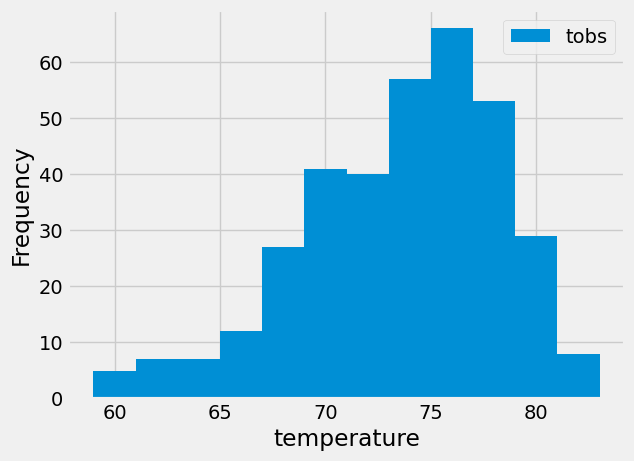

In [34]:

last_12_months_temp_df.plot.hist(bins=12)
plt.xlabel('temperature')

# Close session

In [35]:
# Close Session
session.close()